In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from lifelines import CoxPHFitter, KaplanMeierFitter
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection

# Data reading, cleaning and merging

In [2]:
data = pd.read_csv("../summary_data/sbt_features_oncopanel.csv")
data = data.set_index('Sample ID')

data = data.loc[data['Cancer Type'] == 'Colorectal Cancer', ]
data = data.loc[data['Biopsy Site Type'] == 'PRIMARY', ]

## Filtering data

In [3]:
# Remove invalid values
data = data.loc[data['Tumor Purity'] > 0]
data = data.loc[data['offcov'] <= 0.5]

data = data.rename(columns={"Age at Treatment Start":"Age"})
data = data.loc[data['Age'] > 0]

data['Sex'] = data['Sex'] == "Female"
data['Sex'] = data['Sex'].astype(int)

data['Panel Version'] = data['Panel Version'].astype(float)

data['Panel_Version_1'] = data['Panel Version'] == 1.0
data['Panel_Version_1'] = data['Panel_Version_1'].astype(float)

data['Panel_Version_2'] = data['Panel Version'] == 2.0
data['Panel_Version_2'] = data['Panel_Version_2'].astype(float)


data['Line_of_Treatment_0'] = data['Line of Treatment'] == 0
data['Line_of_Treatment_0'] =  data['Line_of_Treatment_0'].astype(float)


data['time'] = data['tstop'] - data['tstart']

N = data.shape[0]

data['rank_age'] = data["Age"].rank(method='first').reindex_like(data["Age"])/N

data["Age_top"] = 0    
data.loc[data['rank_age'] > 0.66, 'Age_top'] = 1

data["Age_bottom"] = 0    
data.loc[data['rank_age'] <= 0.33, 'Age_bottom'] = 1

data["Age_middle"] = 0    
data.loc[(data['rank_age'] > 0.33) & (data['rank_age'] <= 0.66) , 'Age_middle'] = 1

In [4]:
feature_dict_names = {'mtDNA_dosage_norm':'mtDNA copy number', '5S_dosage_norm':'5S rDNA copy number', 
                      '18S_dosage_norm':'18S rDNA copy number', '28S_dosage_norm':'28S rDNA copy number', 
                      '45S_dosage_norm':'45S rDNA copy number', 'n_fungi_norm':'fungal load', 
                      'n_microbial_norm':'microbial load', 'n_protozoa_norm':'protozoa load', 
                      'n_viral_norm':'viral load', 'loadIG_ligth_chain_norm':'IG κ and λ infiltration', 
                      'loadIG_norm':'BCR infiltration', 'loadIGH_norm':'IGH infiltration', 
                      'loadIGK_norm':'IG κ infiltration', 'loadIGL_norm':'IG λ infiltration', 
                      'loadTCR_norm':'T cell infiltration', 'loadTCRA_norm':'T cell α infiltration', 
                      'loadTCRB_norm':'T cell β infiltration', 'loadTCRD_norm':'T cell δ infiltration',
                      'loadTCRG_norm':'T cell γ infiltration', 'nIG_ligth_chain_norm':'IG κ and λ richness', 
                      'nIG_norm':'BCR richness', 'nIGH_norm':'IGH richness', 'nIGK_norm':'IG κ richness', 
                      'nIGL_norm':'IG λ richness', 'nTCR_norm':'TCR richness', 'nTCRA_norm':'TCR α richness', 
                      'nTCRB_norm':'TCR β richness', 'nTCRD_norm':'TCR δ richness', 'nTCRG_norm':'TCR γ richness',
                      'alphaIGH':'IGH Shannon', 'alphaIGK':'IG κ Shannon', 'alphaIGL':'IG λ Shannon', 
                      'alphaTCRA':'TCR α Shannon', 'alphaTCRB':'TCR β Shannon', 'alphaTCRD':'TCR δ Shannon', 
                      'alphaTCRG':'TCR γ Shannon'}

# SBT features, covariates and outcomes

In [5]:
features = ['alphaIGH', 'alphaIGK', 'alphaIGL', 'alphaTCRA', 'alphaTCRB', 'alphaTCRD', 'alphaTCRG', 
            'mtDNA_dosage_norm', 
            '5S_dosage_norm', '18S_dosage_norm','28S_dosage_norm', '45S_dosage_norm', 
            'n_fungi_norm', 'n_microbial_norm', 'n_protozoa_norm', 'n_viral_norm', 
            'loadIGH_norm', 'loadIGK_norm', 'loadIGL_norm', 'loadTCRA_norm', 'loadTCRB_norm','loadTCRD_norm', 'loadTCRG_norm', 
            'nIGH_norm', 'nIGK_norm', 'nIGL_norm', 'nTCRA_norm', 'nTCRB_norm', 'nTCRD_norm', 'nTCRG_norm']


covariates = ['offcov', 'Tumor Purity', 'Age', "Age_top", "Age_middle", "Age_bottom", 'Sex', 
              'Panel_Version_1', 'Panel_Version_2', 'Line_of_Treatment_0']

# Distribution of covariates

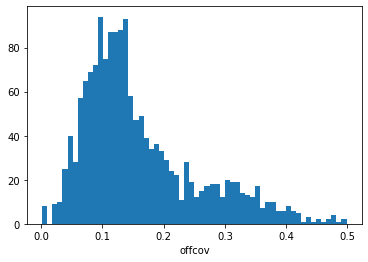

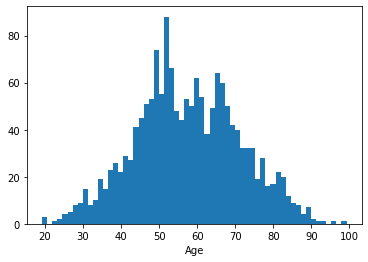

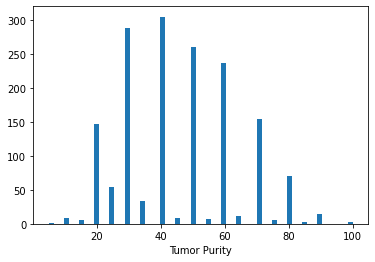

In [6]:
for column in['offcov', 'Age', 'Tumor Purity']:
   
    plt.hist(data[column], bins=60)
    plt.xlabel(column)
    plt.show()

# Zero inflated SBT features ( >10%)

nIG_norm Zero portion:  88.24984539270253 % nonzero inviduals:  190


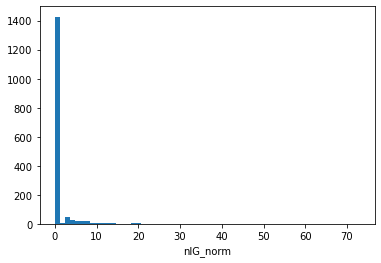

nIG_ligth_chain_norm Zero portion:  92.02226345083488 % nonzero inviduals:  129


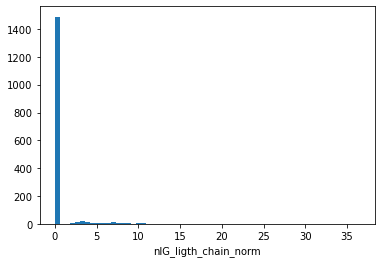

nIGH_norm Zero portion:  93.81570810142239 % nonzero inviduals:  100


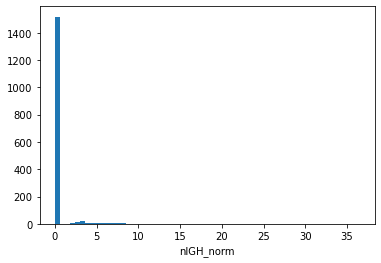

nIGK_norm Zero portion:  100.0 % nonzero inviduals:  0


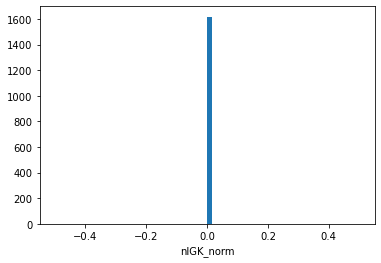

nIGL_norm Zero portion:  92.02226345083488 % nonzero inviduals:  129


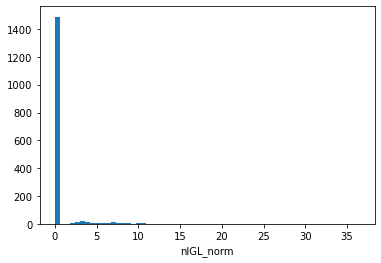

nTCR_norm Zero portion:  47.124304267161406 % nonzero inviduals:  855


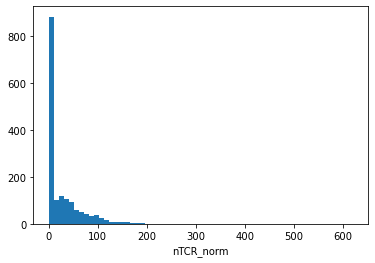

nTCRA_norm Zero portion:  47.30983302411874 % nonzero inviduals:  852


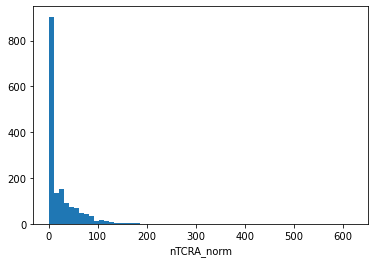

nTCRB_norm Zero portion:  68.46011131725417 % nonzero inviduals:  510


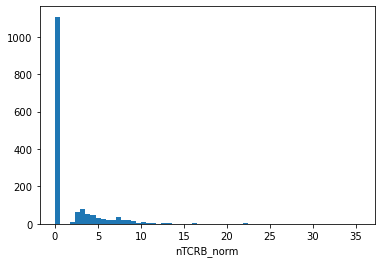

nTCRD_norm Zero portion:  99.56709956709958 % nonzero inviduals:  7


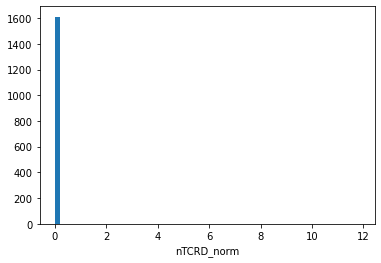

nTCRG_norm Zero portion:  77.61286332714904 % nonzero inviduals:  362


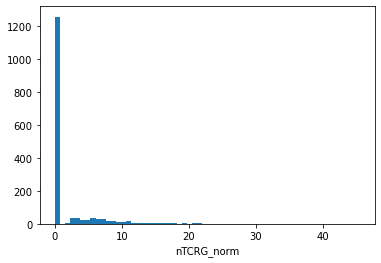

loadIG_norm Zero portion:  88.24984539270253 % nonzero inviduals:  190


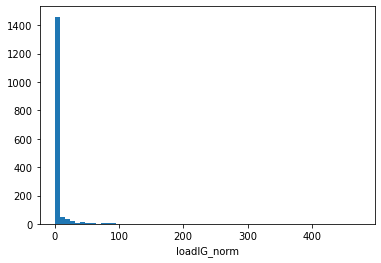

loadIG_ligth_chain_norm Zero portion:  92.02226345083488 % nonzero inviduals:  129


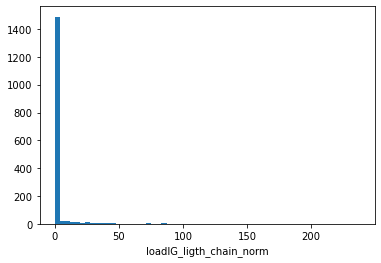

loadIGH_norm Zero portion:  93.81570810142239 % nonzero inviduals:  100


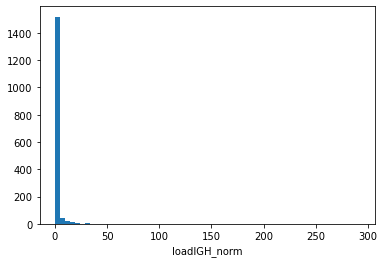

loadIGK_norm Zero portion:  100.0 % nonzero inviduals:  0


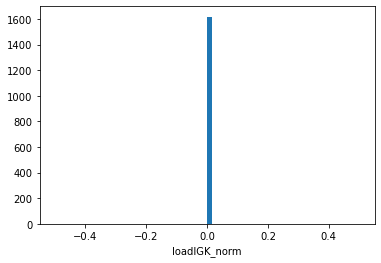

loadIGL_norm Zero portion:  92.02226345083488 % nonzero inviduals:  129


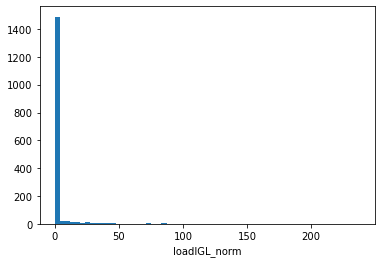

loadTCR_norm Zero portion:  47.124304267161406 % nonzero inviduals:  855


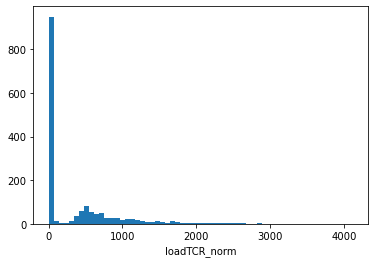

loadTCRA_norm Zero portion:  47.30983302411874 % nonzero inviduals:  852


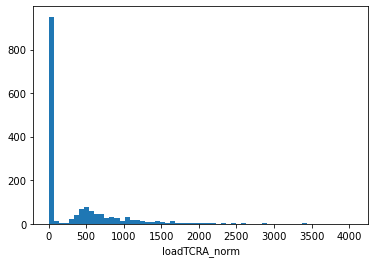

loadTCRB_norm Zero portion:  68.46011131725417 % nonzero inviduals:  510


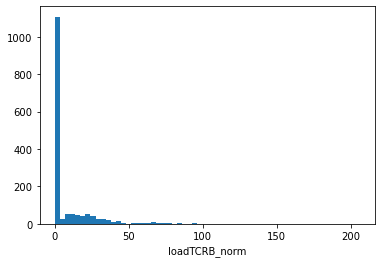

loadTCRD_norm Zero portion:  99.56709956709958 % nonzero inviduals:  7


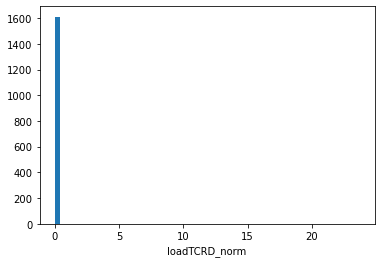

loadTCRG_norm Zero portion:  77.61286332714904 % nonzero inviduals:  362


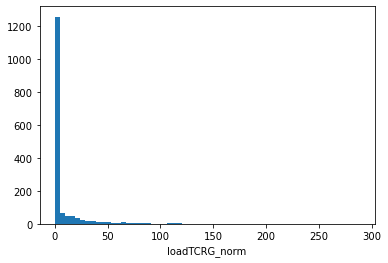

alphaIGH Zero portion:  98.4539270253556 % nonzero inviduals:  25


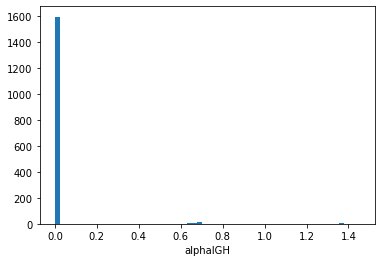

alphaIGK Zero portion:  100.0 % nonzero inviduals:  0


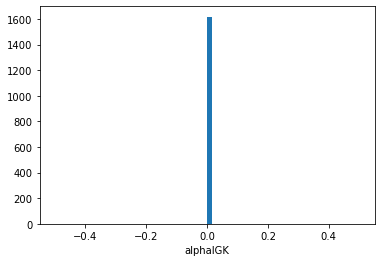

alphaIGL Zero portion:  98.08286951144095 % nonzero inviduals:  31


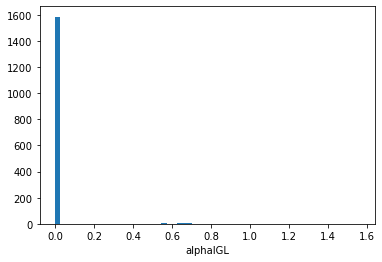

alphaTCRA Zero portion:  57.45207173778603 % nonzero inviduals:  688


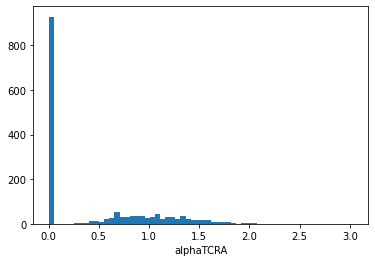

alphaTCRB Zero portion:  93.75386518243661 % nonzero inviduals:  101


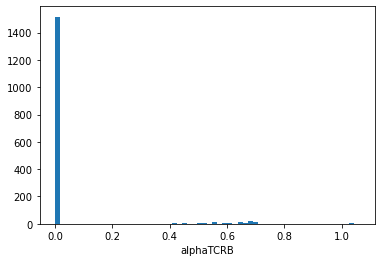

alphaTCRD Zero portion:  100.0 % nonzero inviduals:  0


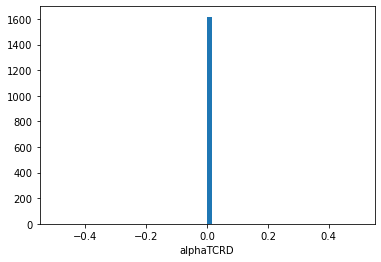

alphaTCRG Zero portion:  89.73407544836117 % nonzero inviduals:  166


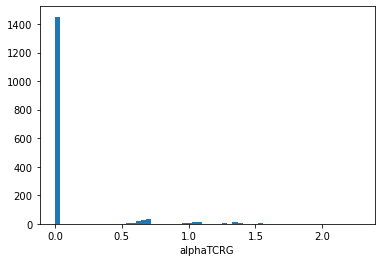

In [7]:
features_zero_inflated_ = ['nIG_norm', 'nIG_ligth_chain_norm', 'nIGH_norm',  'nIGK_norm',  'nIGL_norm', 
                            'nTCR_norm', 'nTCRA_norm',  'nTCRB_norm',  'nTCRD_norm',  'nTCRG_norm',  
                           'loadIG_norm', 'loadIG_ligth_chain_norm', 
                           'loadIGH_norm',  'loadIGK_norm',  'loadIGL_norm', 
                           'loadTCR_norm', 'loadTCRA_norm',  'loadTCRB_norm',  'loadTCRD_norm',  'loadTCRG_norm',
                           'alphaIGH',  'alphaIGK',  'alphaIGL',  
                           'alphaTCRA',  'alphaTCRB',  'alphaTCRD',  'alphaTCRG']

features_zero_inflated = []

# number of rows
N = data.shape[0]

for feature in features_zero_inflated_:
   
    # number of zeros
    n_zeros = len(data.loc[data[feature] == 0, feature])
    
    # features and portion of zeros
    print(feature, "Zero portion: ",n_zeros/N*100, "%","nonzero inviduals: " ,N - n_zeros)
    
    if N - n_zeros > 30:
        features_zero_inflated.append(feature)
    
    plt.hist(data[feature], bins=60)
    plt.xlabel(feature)
    plt.show()
    

data_zero_inflated = data[features_zero_inflated]



## Variable transformation

### _Q: variable created by inverse normal transformation on non-zero values  
### Formula: qnorm((rank(x,na.last="keep")-0.5)/sum(!is.na(x)))


### _D: dichotomous variable indicating non-zero values (value 1) and zero values (value 0)


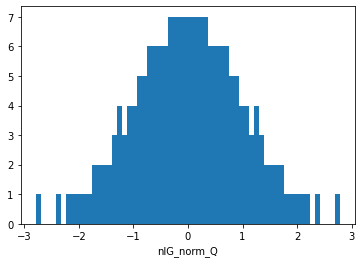

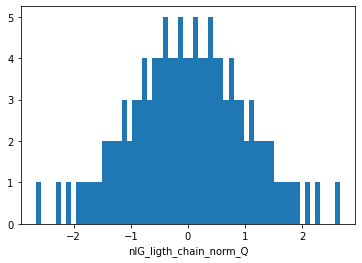

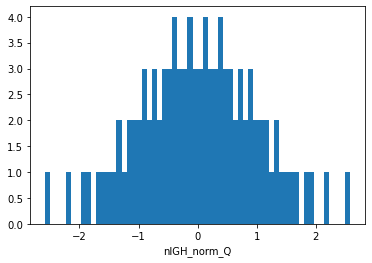

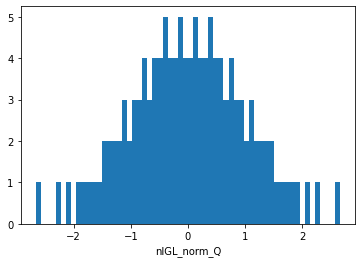

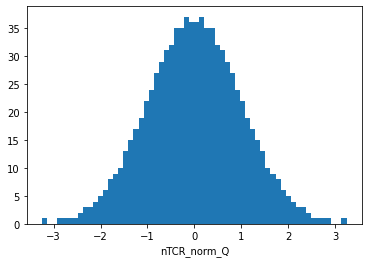

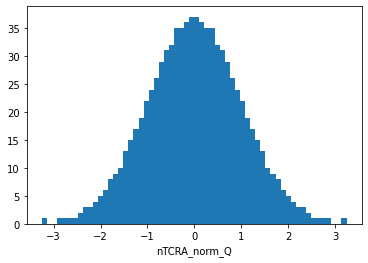

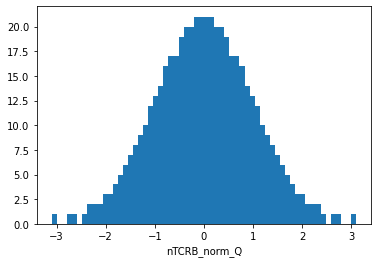

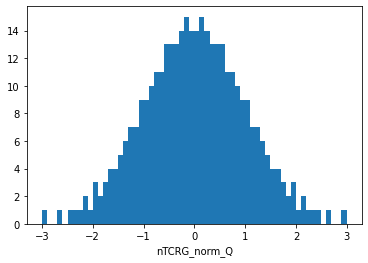

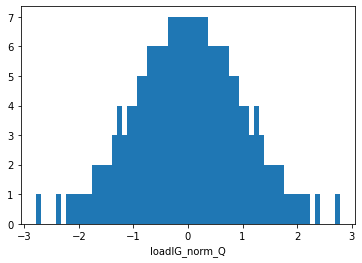

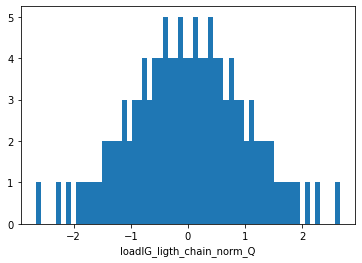

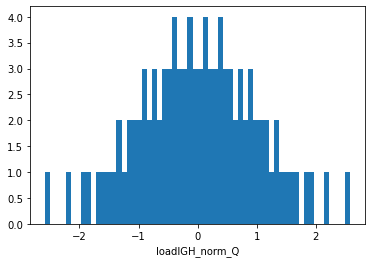

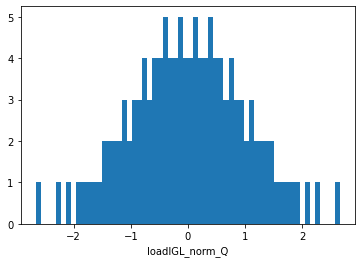

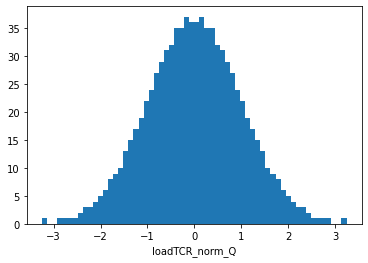

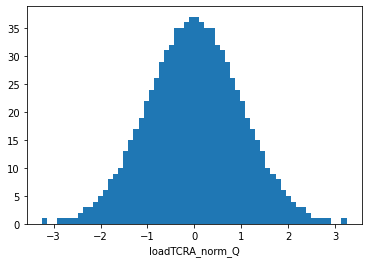

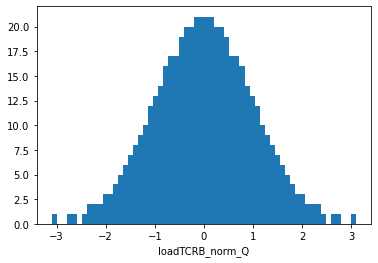

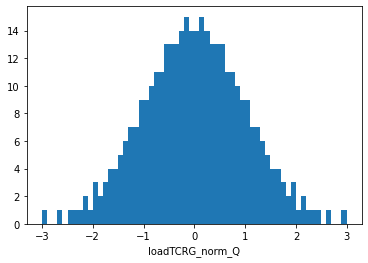

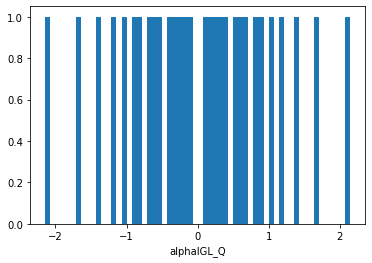

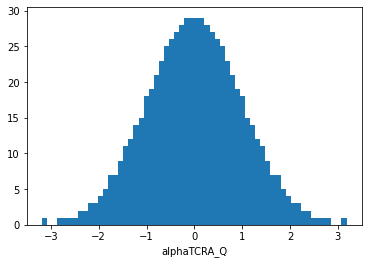

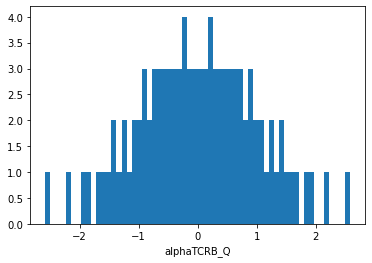

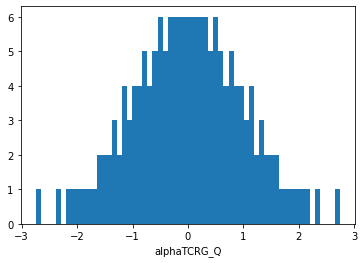

In [8]:
data_zero_inflated_Q = data_zero_inflated.copy()
data_zero_inflated_D = data_zero_inflated.copy()

for feature in features_zero_inflated[0:]:
    
    # Dichotomous variable (_D) with 0 for zero values and 1 otherwise
    data_zero_inflated_D.loc[data_zero_inflated_D[feature] != 0. , feature] = 1.
    
    
    # Inverse normal transformation of non-zero values
    data_feature = data_zero_inflated.loc[data_zero_inflated[feature] != 0., feature]
    data_feature = data_feature.rank(method='first').reindex_like(data_feature)

    for row in data_feature.index: 

        x = norm.ppf((data_feature[row]-0.5)/len(data_feature))
        data_zero_inflated_Q[feature][row] = x
        
        
    # renaming columns   
    data_zero_inflated_Q = data_zero_inflated_Q.rename(columns={feature: feature+"_Q"}, errors="raise")
    data_zero_inflated_D = data_zero_inflated_D.rename(columns={feature: feature+"_D"}, errors="raise")
    
    #Checking new distribution - non-zero values
    x = data_zero_inflated_Q.loc[data_zero_inflated_Q[feature+"_Q"] != 0, feature+"_Q"]
    plt.hist(x, bins=60)
    plt.xlabel(feature+"_Q")
    plt.show()

# Cox regression

In [9]:
data_ = data.copy()
data_ = data_.join(data_zero_inflated_D, on='Sample ID')
data_ = data_.join(data_zero_inflated_Q, on='Sample ID')

Ncovs = 8

#Dataframe to store results
col_names = ['sbt_feature', 'pvalue', 'effect', 'std']

result = pd.DataFrame(columns = col_names)


for feature in features_zero_inflated:
    
    data_rank = data_.copy()
    data_rank = data_rank[['time', 'event', feature+"_D",  feature+"_Q", feature,
                            'Age_top', 'Age_bottom', 'Sex', 'Tumor Purity', 'offcov',
                            'Panel_Version_1',  'Panel_Version_2', 'Line_of_Treatment_0']]
    data_rank = data_rank.dropna()

    # -----------------------------------------------------------------------------------------------------
    # Regression with SBT features

       
    
    df = data_rank[['time', 'event', feature+"_D",  feature+"_Q",
                    'Age_top', 'Age_bottom', 'Sex', 'Tumor Purity', 'offcov',
                    'Panel_Version_1',  'Panel_Version_2', 'Line_of_Treatment_0']]
    
    cph = CoxPHFitter()
    
    if feature in ['alphaIGL', 'alphaTCRA']:
         cph.fit(df, duration_col='time', event_col='event', strata=['Line_of_Treatment_0', 'Panel_Version_2'])
    else:
        cph.fit(df, duration_col='time', event_col='event', strata=['Line_of_Treatment_0'])
        
    params = cph.summary
    
     # storing the largest effect
    effect = params['coef'][feature+"_Q"]
    error = cph.standard_errors_[feature+"_Q"]
    if abs(effect) < abs(params['coef'][feature+"_D"]):
        effect = params['coef'][feature+"_D"]
        error = cph.standard_errors_[feature+"_D"]
        
        
    L1 = cph.log_likelihood_
   
    cph.check_assumptions(df, p_value_threshold=0.05/Ncovs, show_plots=False)
    
    
    
    # -----------------------------------------------------------------------------------------------------
    # Regression with only covariates
    df = data_rank[['time', 'event',
                    'Age_top', 'Age_bottom', 'Sex', 'Tumor Purity', 'offcov',
                    'Panel_Version_1',  'Panel_Version_2', 'Line_of_Treatment_0']]
    
    cph = CoxPHFitter()

    if feature in ['alphaIGL', 'alphaTCRA']:
         cph.fit(df, duration_col='time', event_col='event', strata=['Line_of_Treatment_0', 'Panel_Version_2'])
   
    else:
        cph.fit(df, duration_col='time', event_col='event', strata=['Line_of_Treatment_0'])
    
    L2 = cph.log_likelihood_
    pvalue = 1 - stats.chi2.cdf(2*(L1 - L2), 2)
    
    cph.check_assumptions(df, p_value_threshold=0.05/Ncovs, show_plots=False)
    
    
    result = result.append({'sbt_feature': feature_dict_names[feature], 
                            'pvalue': pvalue,
                            'effect': effect, 
                            'std':error}, 
                            ignore_index=True)

    
result_zero_inflated_survival = result

Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
The ``p_value_threshold`` is set at 0.00625. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using 



1. Variable 'offcov' failed the non-proportional test: p-value is 0.0044.

   Advice 1: the functional form of the variable 'offcov' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'offcov' using pd.cut, and then specify it in
`strata=['offcov', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduc



1. Variable 'offcov' failed the non-proportional test: p-value is 0.0039.

   Advice 1: the functional form of the variable 'offcov' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'offcov' using pd.cut, and then specify it in
`strata=['offcov', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduc

# SBT features without zero inflation

mtDNA_dosage_norm  - Zero portion:  0.0006184291898577613 %


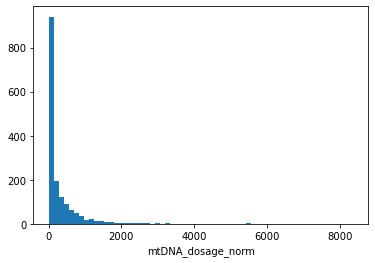

5S_dosage_norm  - Zero portion:  0.0 %


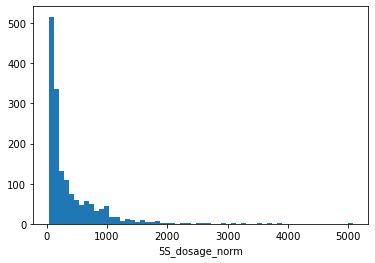

18S_dosage_norm  - Zero portion:  0.011131725417439703 %


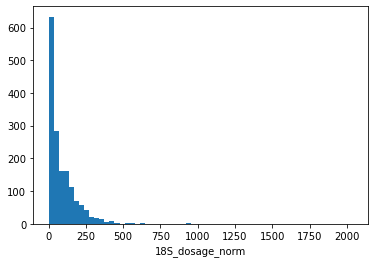

28S_dosage_norm  - Zero portion:  0.0024737167594310453 %


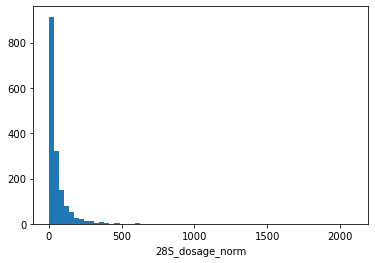

45S_dosage_norm  - Zero portion:  0.0006184291898577613 %


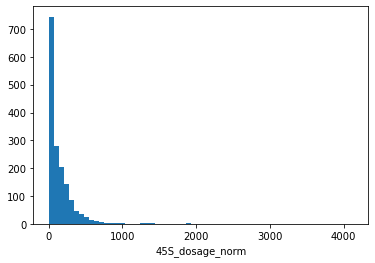

n_fungi_norm  - Zero portion:  0.0 %


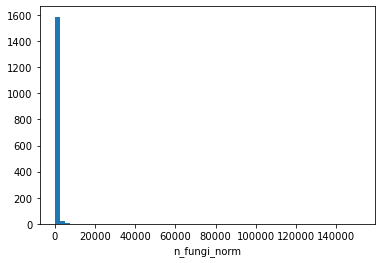

n_microbial_norm  - Zero portion:  0.0 %


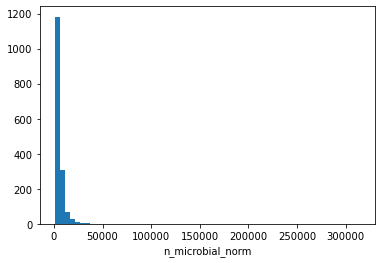

n_protozoa_norm  - Zero portion:  0.0012368583797155227 %


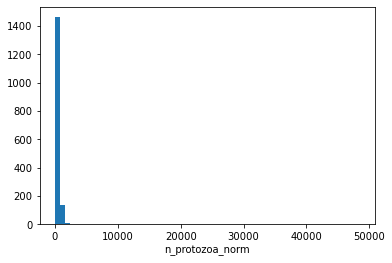

n_viral_norm  - Zero portion:  0.0 %


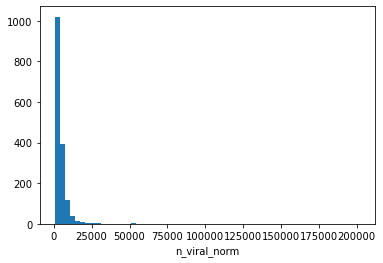

In [10]:
features_non_zero_inflated=['mtDNA_dosage_norm',
                            '5S_dosage_norm','18S_dosage_norm','28S_dosage_norm','45S_dosage_norm',
                            'n_fungi_norm','n_microbial_norm','n_protozoa_norm','n_viral_norm']

# number of rows
N = data.shape[0]

for feature in features_non_zero_inflated:
   
    # number of zeros
    n_zeros = len(data.loc[data[feature] == 0, feature])
    
    # features and portion of zeros
    print(feature, " - Zero portion: ",n_zeros/N, "%")
    plt.hist(data[feature], bins=60)
    plt.xlabel(feature)
    plt.show()

data_non_zero_inflated = data[features_non_zero_inflated]

## Variable transformation

### _Q: variable created by inverse normal transformation (qnorm((rank(x,na.last="keep")-0.5)/sum(!is.na(x))))
### _D: dichotomous variable indicating top 15% (value 1) and bottom 85% (value 0)

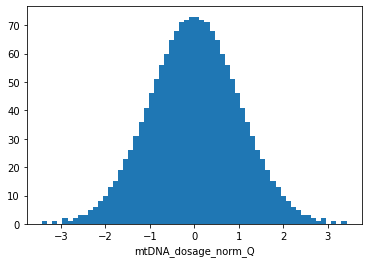

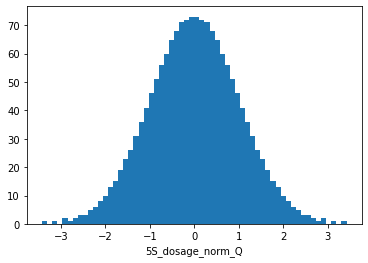

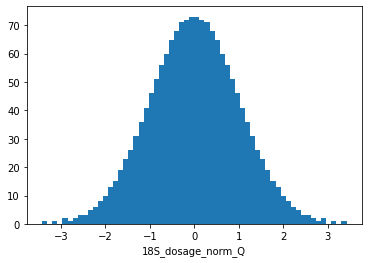

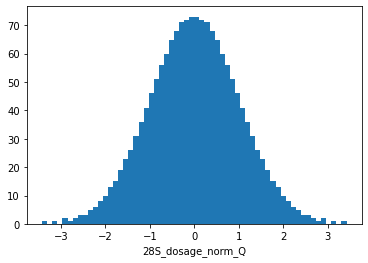

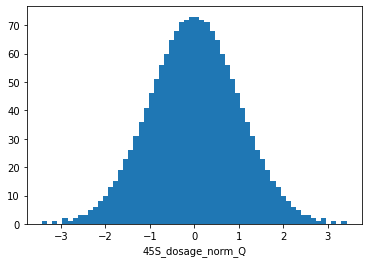

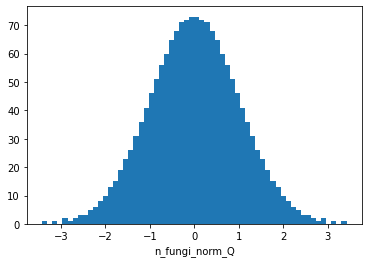

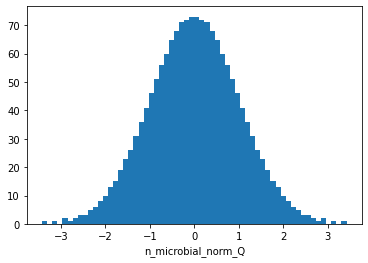

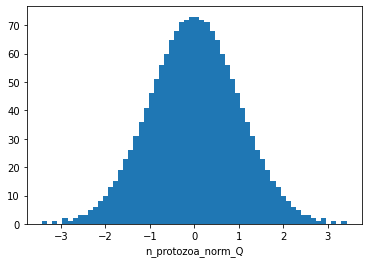

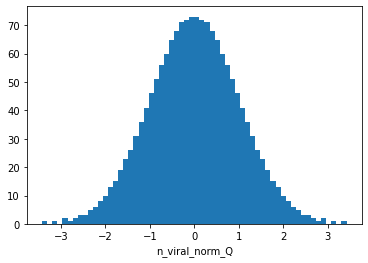

In [11]:
data_non_zero_inflated_Q = data_non_zero_inflated.copy()

N = data_non_zero_inflated.shape[0]

data_non_zero_inflated_D = data_non_zero_inflated.rank()/N  

for feature in features_non_zero_inflated:
    
    # Dichotomous variable with 0 for the bottom 85% of data and 1 for the top 15% 
    data_non_zero_inflated_D.loc[data_non_zero_inflated_D[feature] < 0.85, feature] = 0.
    data_non_zero_inflated_D.loc[data_non_zero_inflated_D[feature] >= 0.85, feature] = 1.
    
    
    # Inverse normal transformation
    data_feature = data_non_zero_inflated[feature]
    data_feature = data_feature.rank(method='first').reindex_like(data_feature)

    for row in data_feature.index: 

        x = norm.ppf((data_feature[row]-0.5)/len(data_feature))
        data_non_zero_inflated_Q[feature][row] = x
        
        
    # renaming columns   
    data_non_zero_inflated_Q = data_non_zero_inflated_Q.rename(columns={feature: feature+"_Q"}, errors="raise")
    data_non_zero_inflated_D = data_non_zero_inflated_D.rename(columns={feature: feature+"_D"}, errors="raise")
    
    #Checking new distribution - non-zero values
    x = data_non_zero_inflated_Q.loc[data_non_zero_inflated_Q[feature+"_Q"] != 0, feature+"_Q"]
    plt.hist(x, bins=60)
    plt.xlabel(feature+"_Q")
    plt.show()

# Cox Regression

In [12]:
data_ = data.copy()
data_ = data_.join(data_non_zero_inflated_D, on='Sample ID')
data_ = data_.join(data_non_zero_inflated_Q, on='Sample ID')
Ncovs = 8

#Dataframe to store results
col_names = ['sbt_feature', 'pvalue', 'effect', 'std']
result  = pd.DataFrame(columns = col_names)


for feature in features_non_zero_inflated:
    
    
    data_rank = data_.copy()
    data_rank = data_rank[['time', 'event', feature+"_D",  feature+"_Q", feature,
                           'Age_top', 'Age_bottom', 'Sex', 'Tumor Purity', 'offcov',
                           'Panel_Version_1',  'Panel_Version_2', 'Line_of_Treatment_0']]

    data_rank = data_rank.dropna() 

    # -----------------------------------------------------------------------------------------------------
    # Regression with _Q        
    
    df = data_rank[['time', 'event', feature+"_Q",
                    'Age_top', 'Age_bottom', 'Sex', 'Tumor Purity', 'offcov',
                    'Panel_Version_1',  'Panel_Version_2', 'Line_of_Treatment_0']]  
    
    cph = CoxPHFitter()      
    
    if feature in ['mtDNA_dosage_norm', '5S_dosage_norm', '18S_dosage_norm', '28S_dosage_norm', '45S_dosage_norm']:   
        cph.fit(df, duration_col='time', event_col='event', strata=['Line_of_Treatment_0', 'Panel_Version_2'])
    else:
        cph.fit(df, duration_col='time', event_col='event', strata=['Line_of_Treatment_0'])
        
    error = cph.standard_errors_[feature+"_Q"]
    params_Q = cph.summary 
    
    cph.check_assumptions(df, p_value_threshold=0.05/Ncovs, show_plots=False)
   
    result = result.append({'sbt_feature': feature_dict_names[feature], 
                            'pvalue': params_Q['p'][feature+"_Q"] ,
                            'effect': params_Q['coef'][feature+"_Q"], 
                            'std':error}, 
                            ignore_index=True)

result_non_zero_inflated_survival = result

Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.


In [13]:
result = pd.concat([result_non_zero_inflated_survival,result_zero_inflated_survival])

features_failed = [feature_dict_names['loadTCRB_norm'], feature_dict_names['nTCRB_norm']]

for feature in features_failed:
    result = result.loc[~ (result['sbt_feature'] == feature),]
    
result['qvalue'] = fdrcorrection(result['pvalue'])[1]
result.to_csv('../summary_data/survival_results_op-crc_primary.csv', index=False)
result.loc[(result['qvalue'] < 0.1) ,]


,sbt_feature,pvalue,effect,std,qvalue
0,mtDNA copy number,2.824066e-02,0.116823,0.053248,5.083319e-02
1,5S rDNA copy number,4.560788e-03,0.168003,0.059229,1.026177e-02
2,18S rDNA copy number,3.353137e-05,0.242263,0.058404,1.131684e-04
3,28S rDNA copy number,3.316018e-09,0.339644,0.057419,8.953250e-08
4,45S rDNA copy number,4.876859e-07,0.296253,0.058884,3.291880e-06
5,fungal load,3.515508e-08,0.320843,0.058191,4.745936e-07
6,microbial load,2.350564e-05,0.215572,0.050978,9.066460e-05
7,protozoa load,3.607305e-07,0.280236,0.055072,3.246575e-06
8,viral load,2.049421e-04,0.185294,0.049906,6.148263e-04
4,TCR richness,4.187798e-03,0.334564,0.141530,1.026177e-02
